In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

For current list of general ideas, etc. see `README_canonical_stays.md`

## Notes: 

### 2-stays
* gap-merging works well when good density; poorly when otherwise


In [4]:
import numpy as np
import pandas as pd

In [5]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [6]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [8]:
shuffle(colors)

# Sythetic data

In [9]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [10]:
from synthetic_data.canonical_stays import get1, get2, get3e, get3, get3_core, gen_stays

In [11]:
time_thresh = 1/6
dist_thresh=0.25

In [12]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

In [13]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask

In [14]:
get_2_stays = lambda n: 11.4*np.random.rand(n) - 5.7

In [48]:
event_frac = 0.05 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

stays = get2(0, -1.5)
#stays = get1()

time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

clusters = get_clusters(time_arr, noise_arr, dist_thresh, time_thresh)
print(len(clusters))

clusters_rev = get_clusters_rev(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)
print(len(clusters_rev))

'''plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);''';

14
17


# Clustering

## Split the clusters which have a temporal gap

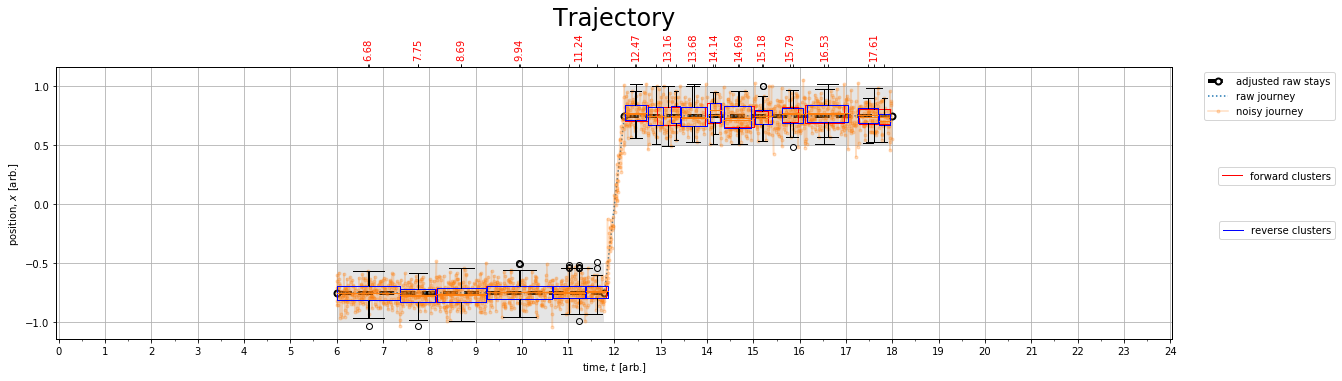

In [49]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [17]:
from helper__metric_box__explore import eval_synth_data

In [18]:
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters)
print('forward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters_rev)
print('backward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

forward
 0.985
 0.987
[[  48   31]
 [  28 2060]]

backward
 0.962
 0.959
[[   0   79]
 [  86 2002]]


## Development

In [19]:
from helper__gaps import merge_clusters

In [20]:
from helper__metric_box__explore import get_cluster_boxplot, kwargs_filled, kwargs_unfilled

### Early gap-method

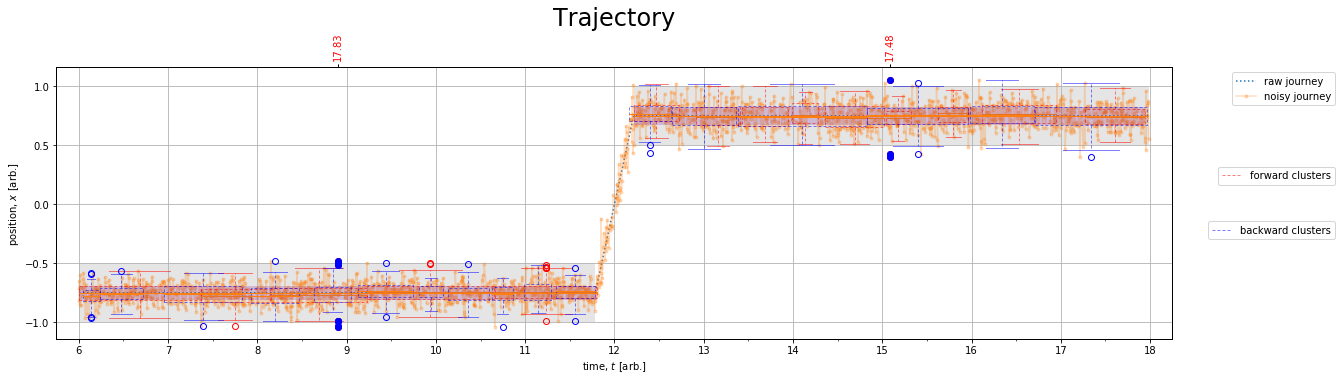

In [50]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.set_xlim([5.75,18.25])

axt = ax.twiny()

kwargs_unfilled['color'] = 'red'
kwargs_unfilled['legend_label'] = 'forward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.6)

kwargs_filled['color'] = 'red'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.6)

axt = get_cluster_boxplot(clusters, time_arr, noise_arr, axt, **kwargs_unfilled)

new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, 3*time_thresh)
axt = get_cluster_boxplot(new_clusters, time_arr, noise_arr, axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')
axt.set_xlim(ax.get_xlim())


axt = ax.twiny()

kwargs_unfilled['color'] = 'blue'
kwargs_unfilled['legend_label'] = 'backward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.4)

kwargs_filled['color'] = 'blue'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.4)

axt = get_cluster_boxplot(clusters_rev, time_arr, noise_arr, axt, **kwargs_unfilled)

new_clusters_rev = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, 3*time_thresh)
axt = get_cluster_boxplot(new_clusters_rev, time_arr, noise_arr, axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)    
axt.set_xticklabels(labels, visible=False)
axt.set_xlim(ax.get_xlim())


ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [22]:
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters)
print('forward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_rev)
print('backward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

forward
 0.985
 0.998
[[  48   31]
 [   5 2083]]

backward
 0.985
 0.998
[[  48   31]
 [   5 2083]]


### Later gap method

Let stat. metric be $\bar{x}_i$ for $\mathrm{cluster}_i$'s location for $i=1,2$,
<br/>
and $d(\bar{x}_1,\bar{x}_2) < \delta$
<br/>
and $t_1$ is the last timepoint of $\mathrm{cluster}_1$ and $t_2$ is the first for $\mathrm{cluster}_2$,

Then, for all $t\in[t_1,t_2]$, $\exists$ an $\bar{x}$ $\$$ 
1. the duration of $\Delta t := t_2-t_1 \geq \tau$ + travel time with minimum velocity $v = 3.5$ km/hr
    * e.g. let $\bar{x}_1 = \bar{x}_2$ and $d(\bar{x}_1,\bar{x}) = 2\delta$,
    then, the overall duration $\Delta t = 2\cdot 2\delta/v + \tau$
    * specifically: $\bar{x}_1 = 0$, $d(\bar{x}_1,\bar{x}) = 2$km, then $\Delta t \geq 1.31$hr
2. $d(\bar{x}_1,\bar{x}) < \delta$ and $d(\bar{x},\bar{x}_2) < \delta$


In [24]:
from helper__gaps import get_intercluster_metrics

In [51]:
for c1,c2 in zip(clusters[:-1],clusters[1:]):
    
    gap_time, min_allowed, x_med = get_intercluster_metrics(c1, c2, time_arr, noise_arr, time_thresh, 3.4)
    
    print(f"{gap_time:5.3f}, {min_allowed:5.3f}", 
          gap_time < min_allowed, 
          f"\t{np.median(noise_arr[c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[c2]):7.3f}", 
          f"\t{abs(np.median(noise_arr[c1])-x_med):7.3f} {abs(np.median(noise_arr[c2])-x_med):7.3f}")

0.004, 0.186 True 	 -0.753  -0.796  -0.774 	  0.043   0.022
0.021, 0.207 True 	 -0.774  -0.701  -0.765 	  0.073   0.064
0.004, 0.235 True 	 -0.765  -0.639  -0.747 	  0.126   0.108
0.018, 0.190 True 	 -0.747  -0.705  -0.742 	  0.042   0.036
0.408, 0.611 True 	 -0.742   0.070   0.768 	  0.811   0.698
0.192, 0.175 False 	  0.768   0.749   0.741 	  0.019   0.008
0.017, 0.196 True 	  0.741   0.689   0.736 	  0.052   0.047
0.045, 0.188 True 	  0.736   0.712   0.761 	  0.024   0.049
0.074, 0.180 True 	  0.761   0.767   0.728 	  0.006   0.039
0.017, 0.263 True 	  0.728   0.895   0.735 	  0.167   0.160
0.309, 0.179 False 	  0.735   0.754   0.777 	  0.019   0.023
0.161, 0.192 True 	  0.777   0.728   0.765 	  0.049   0.038
0.324, 0.174 False 	  0.765   0.745   0.739 	  0.020   0.006


In [26]:
from helper__gaps import merge_cluster_pair, gap_criterion_2, merge_clusters_2

In [52]:
[gap_criterion_2(dist_thresh, time_thresh)(time_arr,noise_arr,c1,c2) for c1, c2 in zip(clusters[:-1],clusters[1:])]

[True, True, True, True, False, True, True, True, True, True, True, True, True]

In [53]:
new_clusters_2 = merge_clusters_2(time_arr, noise_arr, clusters, dist_thresh, time_thresh, 3.5, True)

[True, True, True, True, False, True, True, True, True, True, True, True, True] 
 ['0.021', '0.009', '0.018', '0.005', '1.510', '0.027', '0.005', '0.025', '0.033', '0.008', '0.041', '0.011', '0.026'] 
 6
[True, True, True, True, False, True, True, True, True, True, True, True] 
 ['0.021', '0.009', '0.018', '0.005', '1.510', '0.028', '0.021', '0.033', '0.008', '0.041', '0.011', '0.026'] 
 3
[True, True, True, False, True, True, True, True, True, True, True] 
 ['0.021', '0.009', '0.019', '1.514', '0.028', '0.021', '0.033', '0.008', '0.041', '0.011', '0.026'] 
 7
[True, True, True, False, True, True, True, True, True, True] 
 ['0.021', '0.009', '0.019', '1.514', '0.028', '0.021', '0.025', '0.041', '0.011', '0.026'] 
 1
[True, True, False, True, True, True, True, True, True] 
 ['0.016', '0.023', '1.514', '0.028', '0.021', '0.025', '0.041', '0.011', '0.026'] 
 7
[True, True, False, True, True, True, True, True] 
 ['0.016', '0.023', '1.514', '0.028', '0.021', '0.025', '0.030', '0.026'] 
 0
[

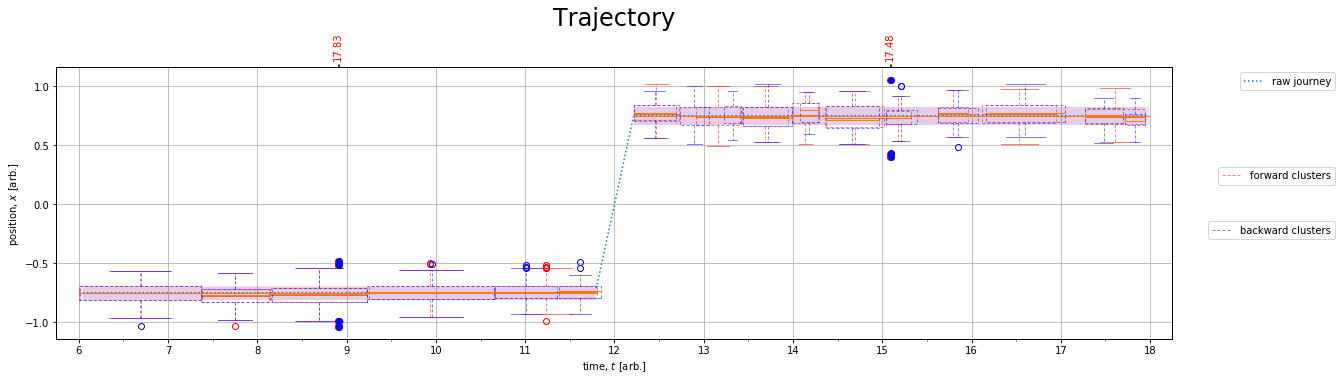

In [54]:
ax = plot_trajectory(time_arr, raw_arr, None, None, None, configs['dist_thresh']);
#add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.set_xlim([5.75,18.25])

axt = ax.twiny()

kwargs_unfilled['color'] = 'red'
kwargs_unfilled['legend_label'] = 'forward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.6)

kwargs_filled['color'] = 'red'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.6)

axt = get_cluster_boxplot(clusters, time_arr, noise_arr, axt, **kwargs_unfilled)

new_clusters_2 = merge_clusters_2(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
axt = get_cluster_boxplot(new_clusters_2, time_arr, noise_arr, axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')
axt.set_xlim(ax.get_xlim())


axt = ax.twiny()

kwargs_unfilled['color'] = 'blue'
kwargs_unfilled['legend_label'] = 'backward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.4)

kwargs_filled['color'] = 'blue'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.4)

axt = get_cluster_boxplot(clusters_rev, time_arr[::-1], noise_arr[::-1], axt, **kwargs_unfilled)
new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], clusters, dist_thresh, time_thresh)
axt = get_cluster_boxplot(new_clusters_rev_2, time_arr[::-1], noise_arr[::-1], axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)    
axt.set_xticklabels(labels, visible=False)
axt.set_xlim(ax.get_xlim())


ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [31]:
from helper__gaps import merge_cluster_pair, get_gap_dist

0.004, 0.185 False 	 -0.753  -0.796  -0.774 	  0.043   0.022
0.021, 0.205 False 	 -0.774  -0.701  -0.765 	  0.073   0.064
0.004, 0.232 False 	 -0.765  -0.639  -0.747 	  0.126   0.108
0.018, 0.188 False 	 -0.747  -0.705  -0.742 	  0.042   0.036
0.408, 0.586 False 	 -0.742   0.070   0.768 	  0.811   0.698
0.192, 0.174 True 	  0.768   0.749   0.740 	  0.019   0.009
0.045, 0.188 False 	  0.740   0.712   0.761 	  0.028   0.049
0.074, 0.179 False 	  0.761   0.767   0.728 	  0.006   0.039
0.017, 0.257 False 	  0.728   0.895   0.735 	  0.167   0.160
0.309, 0.178 True 	  0.735   0.754   0.777 	  0.019   0.023
0.161, 0.191 False 	  0.777   0.728   0.765 	  0.049   0.038
0.324, 0.174 True 	  0.765   0.745   0.739 	  0.020   0.006



0.004, 0.185 False 	 -0.753  -0.796  -0.774 	  0.043   0.022
0.021, 0.205 False 	 -0.774  -0.701  -0.765 	  0.073   0.064
0.004, 0.231 False 	 -0.765  -0.639  -0.746 	  0.126   0.107
0.408, 0.587 False 	 -0.746   0.070   0.768 	  0.816   0.698
0.192, 0.174 True 	  0.7

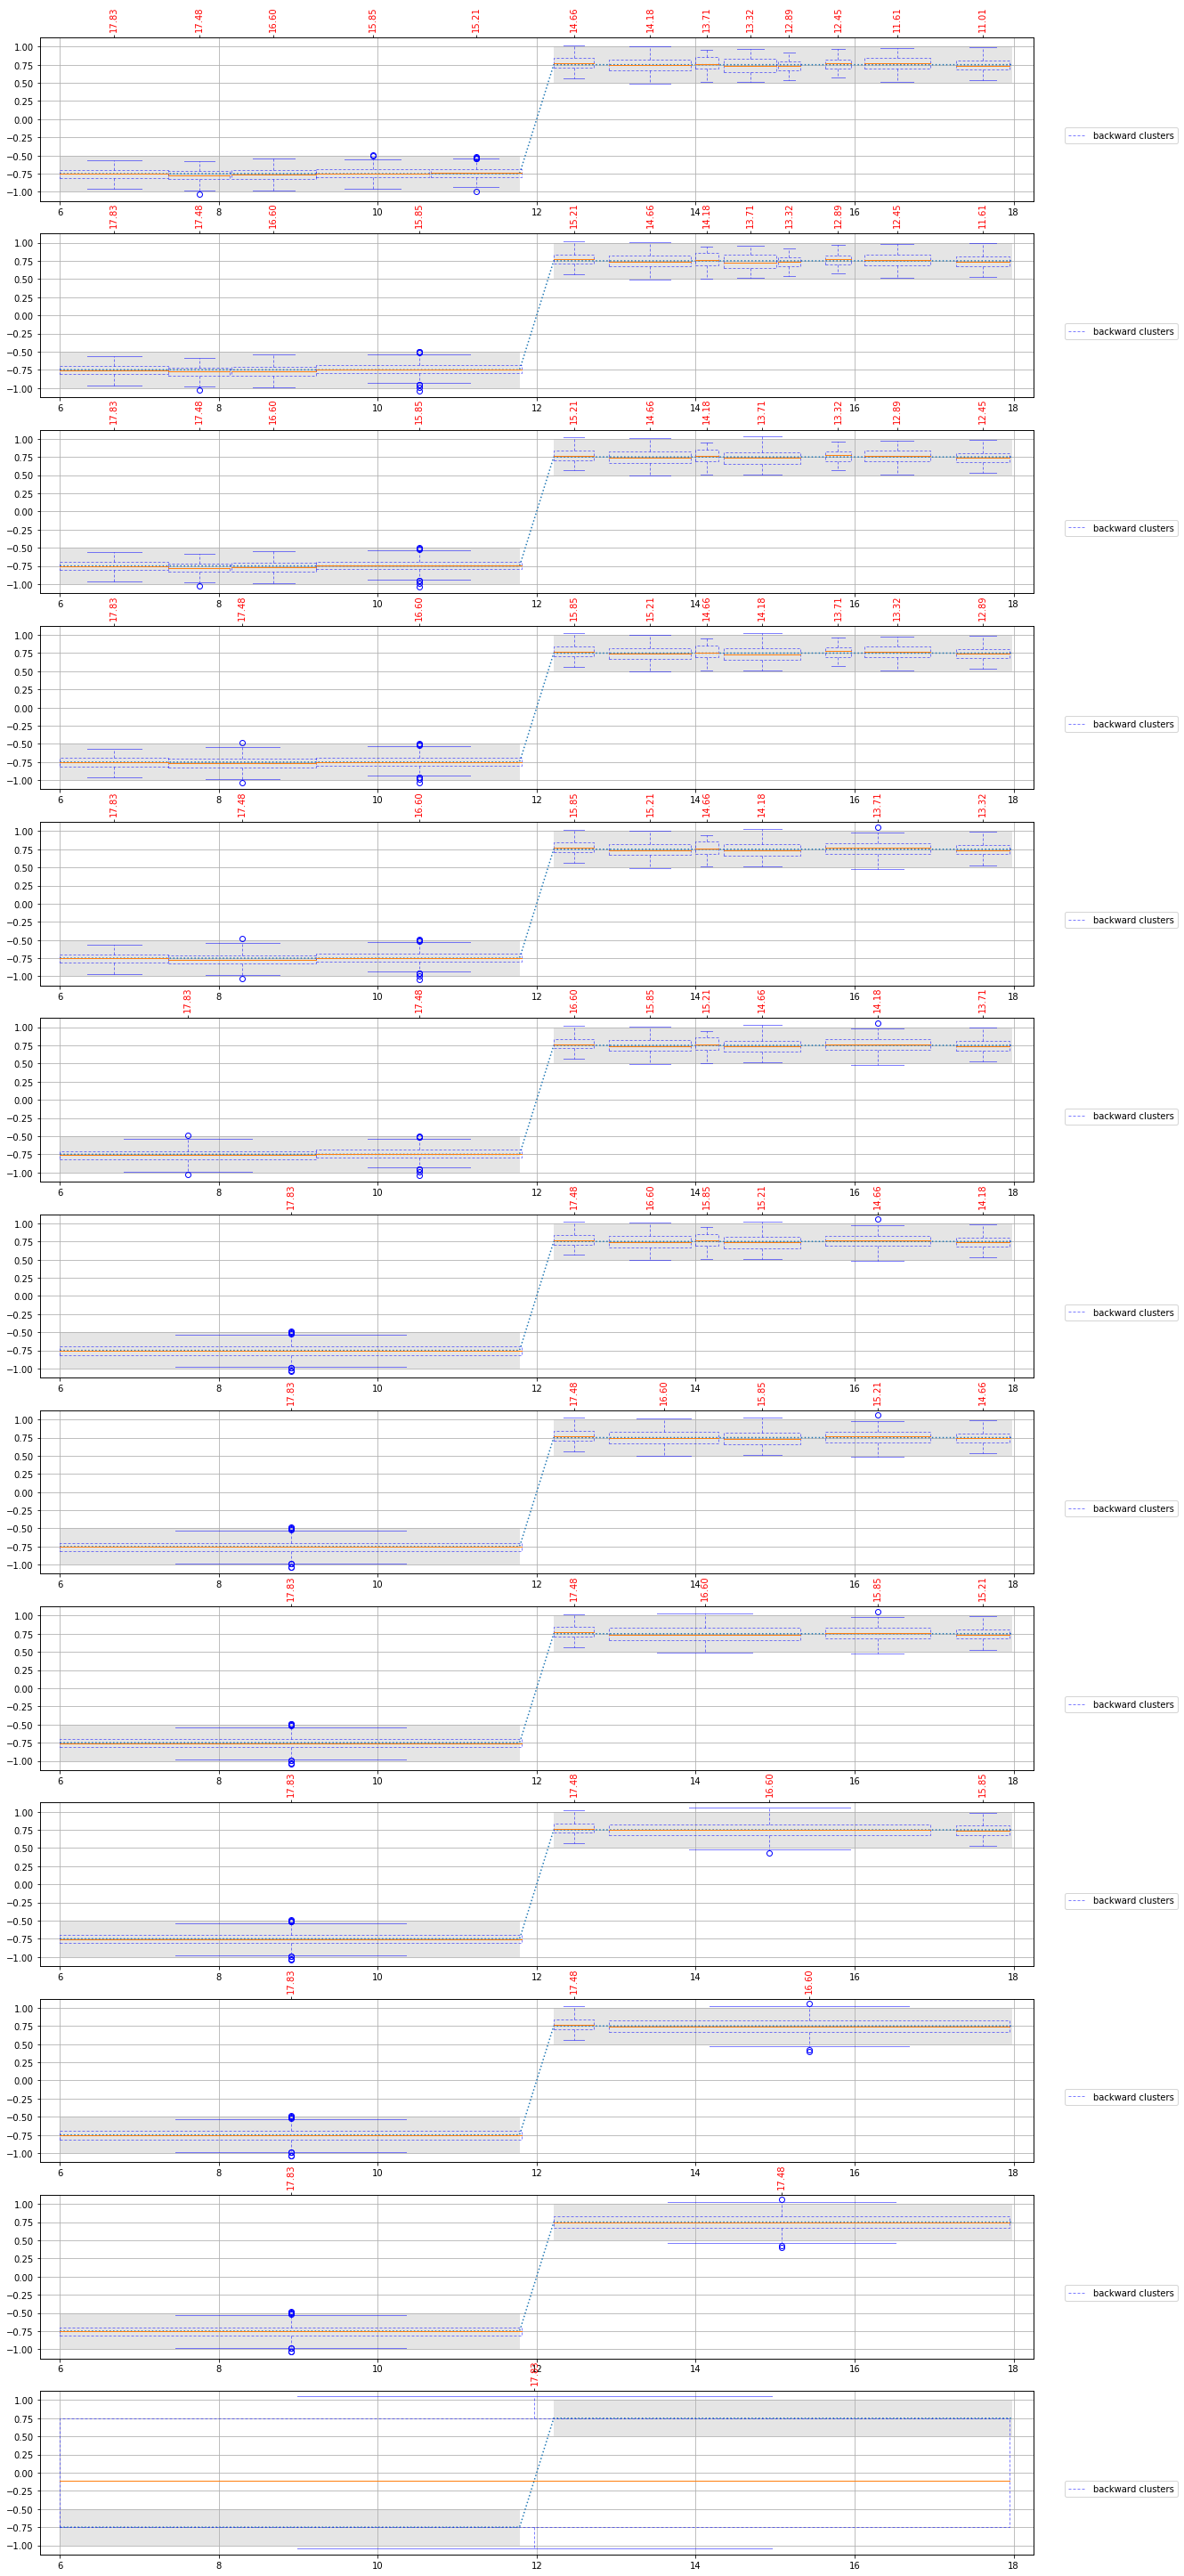

In [55]:
nnn = 13

fig, axs = plt.subplots(nnn,1,figsize=[20,4*nnn])

axs = axs.flatten()

new_clusters2 = clusters.copy()

for n in range(nnn):
    
    ax = axs[n]
    #ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
    ax.plot(time_arr, raw_arr, "C0:")    
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

    ax.set_xlim([5.75,18.25])
    
    ymax = raw_arr.max()+1.5*dist_thresh
    
    ax.set_ylim([-ymax,ymax])
    
    try:
        axt = ax.twiny()

        gaps = [gap_criterion_2(dist_thresh, time_thresh)(time_arr,noise_arr,c1,c2) for c1, c2 in zip(new_clusters2[:-1],new_clusters2[1:])]     
        dists = [get_gap_dist(noise_arr,c1,c2) for c1, c2 in zip(new_clusters2[:-1],new_clusters2[1:])]

        gaps_add = np.array([100*int(not g) for g in gaps])
        dists_add = np.array(dists)+gaps_add

        min_index = np.argmin(dists_add)

        new_clusters2 = merge_cluster_pair(new_clusters2, min_index).copy()

        for c1,c2 in zip(new_clusters2[:-1],new_clusters2[1:]):

            gtime, allowed, x_med = get_intercluster_metrics(c1, c2, time_arr, noise_arr, time_thresh)

            print(f"{gtime:5.3f}, {allowed:5.3f}", 
                  gtime>allowed, 
                  f"\t{np.median(noise_arr[c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[c2]):7.3f}",
                  f"\t{abs(np.median(noise_arr[c1] - x_med)):7.3f} {abs(np.median(noise_arr[c2] - x_med)):7.3f}")
        print('\n\n')   
        axt = get_cluster_boxplot(new_clusters2, time_arr, noise_arr, axt, **kwargs_unfilled)
    except: pass

    for label in axt.get_xticklabels():
        label.set_rotation(90)
    axt.set_xticklabels(labels, visible=True, color='red')
    axt.set_xlim(ax.get_xlim())

    ax.grid()
    #ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);    


0.371, 0.576 False 	  0.746  -0.076  -0.727 	  0.822   0.651
0.024, 0.186 False 	 -0.727  -0.772  -0.748 	  0.045   0.024



0.371, 0.581 False 	  0.746  -0.076  -0.746 	  0.822   0.670








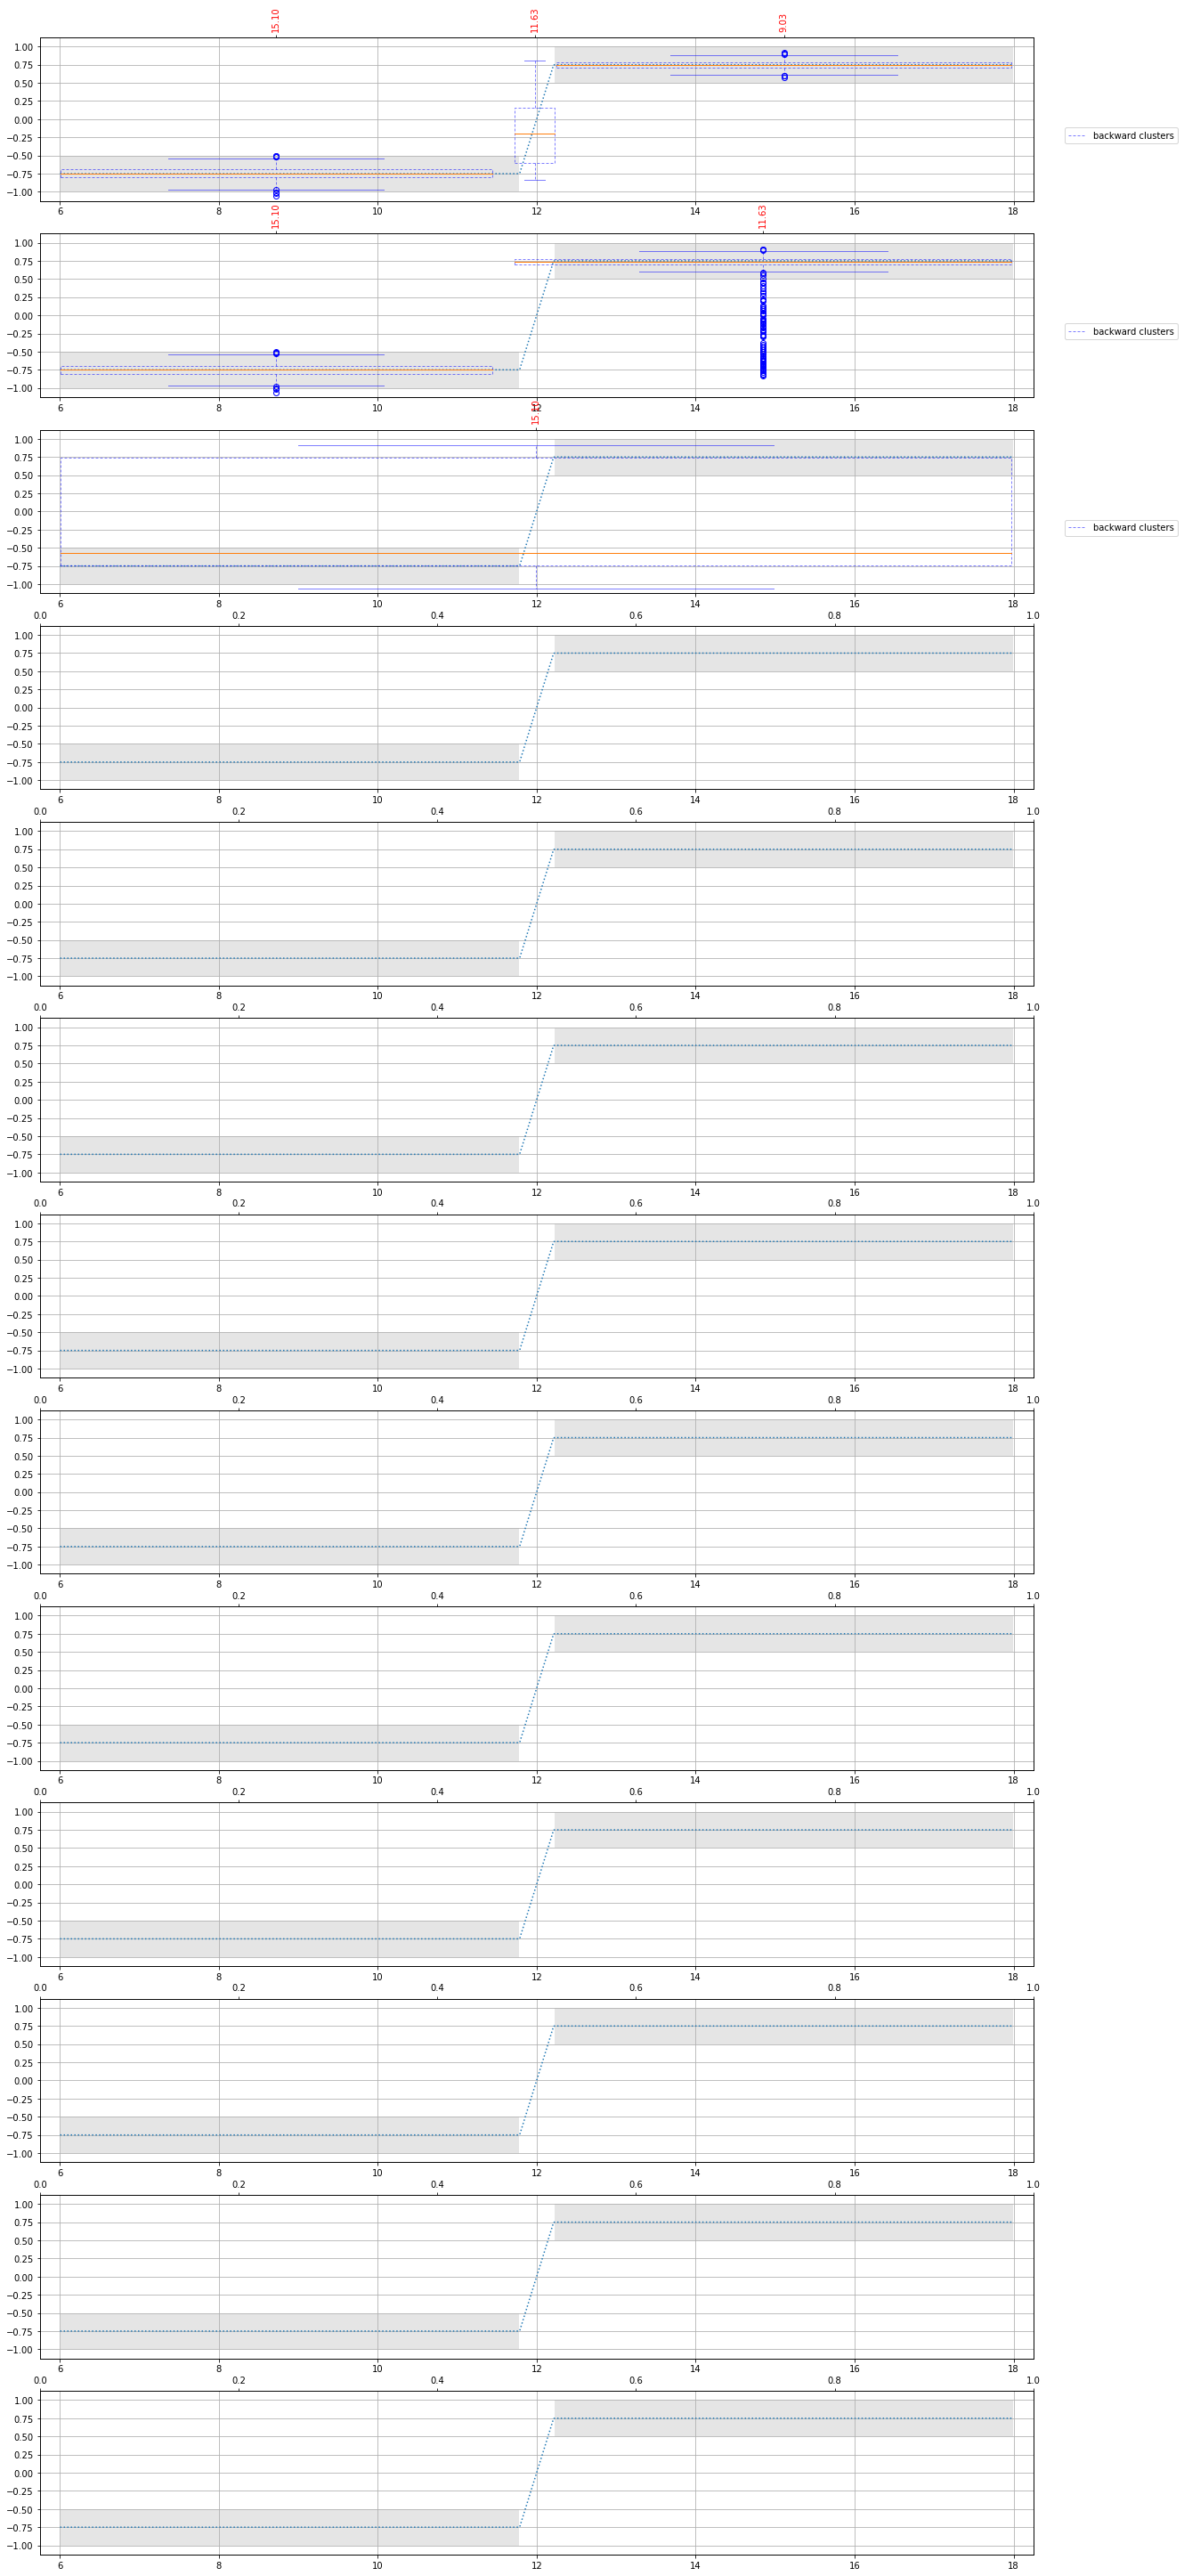

In [38]:
nnn = 13

fig, axs = plt.subplots(nnn,1,figsize=[20,4*nnn])

axs = axs.flatten()

new_clusters_rev2 = clusters_rev.copy()

for n in range(nnn):
    
    ax = axs[n]
    #ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
    ax.plot(time_arr, raw_arr, "C0:")
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

    ax.set_xlim([5.75,18.25])
    
    ymax = raw_arr.max()+1.5*dist_thresh
    
    ax.set_ylim([-ymax,ymax])
    
    try:
        axt = ax.twiny()


        gaps = [gap_criterion_2(dist_thresh, time_thresh)(time_arr[::-1],noise_arr[::-1],c1,c2) for c1, c2 in zip(new_clusters_rev2[:-1],new_clusters_rev2[1:])]     
        dists = [get_gap_dist(noise_arr[::-1],c1,c2) for c1, c2 in zip(new_clusters_rev2[:-1],new_clusters_rev2[1:])]

        gaps_add = np.array([100*int(not g) for g in gaps])
        dists_add = np.array(dists)+gaps_add

        min_index = np.argmin(dists_add)

        new_clusters_rev2 = merge_cluster_pair(new_clusters_rev2, min_index).copy()

        for c1,c2 in zip(new_clusters_rev2[:-1],new_clusters_rev2[1:]):

            gtime, allowed, x_med = get_intercluster_metrics(c1, c2, time_arr[::-1], noise_arr[::-1], time_thresh)

            print(f"{gtime:5.3f}, {allowed:5.3f}", 
                  gtime>allowed, 
                  f"\t{np.median(noise_arr[::-1][c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[::-1][c2]):7.3f}",
                  f"\t{abs(np.median(noise_arr[::-1][c1] - x_med)):7.3f} {abs(np.median(noise_arr[::-1][c2] - x_med)):7.3f}")
        print('\n\n')   
        axt = get_cluster_boxplot(new_clusters_rev2, time_arr, noise_arr, axt, **kwargs_unfilled)


        for label in axt.get_xticklabels():
            label.set_rotation(90)
        axt.set_xticklabels(labels, visible=True, color='red')
        axt.set_xlim(ax.get_xlim())

    except: pass
    
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);    
